## Importing Libraries

In [64]:
import pandas as pd
import numpy as np

In [65]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [66]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [67]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

### custom functions to read the data from csv file and to read signals

In [68]:

def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [69]:
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [70]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [71]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf

tf.set_random_seed(42)

In [72]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [73]:
# Import Keras

from keras import backend as K
# import tensorflow.compat.v1 as tf
# import tensorflow.compat.v1.python.keras.backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)


# sess = K.get_session()

In [74]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.normalization import BatchNormalization

In [75]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [76]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

c:\users\nehar\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


### spliting train data in train and valid

In [77]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.10, random_state=42)

In [78]:
X_train.shape

(6616, 128, 9)

In [79]:
X_valid.shape

(736, 128, 9)

In [80]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
6616


### MODEL 1

In [81]:
epochs = 30
batch_size = 32
n_hidden = 128
pv = 0.25

### Defining the model structure of LSTM

In [82]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
model.add(BatchNormalization())
# Adding a dropout layer
model.add(Dropout(pv))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128)               70656     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 774       
Total params: 71,942
Trainable params: 71,686
Non-trainable params: 256
_________________________________________________________________


In [83]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [84]:
# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_valid, Y_valid),
          epochs=epochs)

Train on 6616 samples, validate on 736 samples
Epoch 1/30
6616/6616 [==============================] - 23s 4ms/step - loss: 0.9965 - accuracy: 0.5778 - val_loss: 0.9147 - val_accuracy: 0.6114
Epoch 2/30
6616/6616 [==============================] - 24s 4ms/step - loss: 0.7300 - accuracy: 0.6377 - val_loss: 0.6895 - val_accuracy: 0.6101
Epoch 3/30
6616/6616 [==============================] - 25s 4ms/step - loss: 0.6448 - accuracy: 0.7051 - val_loss: 0.4824 - val_accuracy: 0.7663
Epoch 4/30
6616/6616 [==============================] - 25s 4ms/step - loss: 0.4428 - accuracy: 0.8378 - val_loss: 0.6608 - val_accuracy: 0.8288
Epoch 5/30
6616/6616 [==============================] - 25s 4ms/step - loss: 0.2799 - accuracy: 0.9046 - val_loss: 0.1817 - val_accuracy: 0.9280
Epoch 6/30
6616/6616 [==============================] - 26s 4ms/step - loss: 0.1997 - accuracy: 0.9290 - val_loss: 0.1533 - val_accuracy: 0.9497
Epoch 7/30
6616/6616 [==============================] - 26s 4ms/step - loss: 0.1829

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


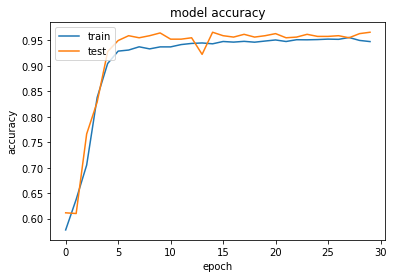

In [85]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

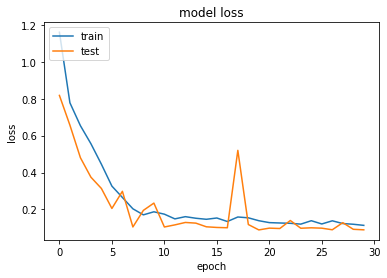

In [97]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Confusion Matrix for true prediction

In [86]:
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  3      380       105        0                   0   
STANDING                 0       86       444        1                   0   
WALKING                  0        0         0      468                  20   
WALKING_DOWNSTAIRS       0        0         0        6                 408   
WALKING_UPSTAIRS         0        2         1        8                   1   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            3  
STANDING                           1  
WALKING                            8  
WALKING_DOWNSTAIRS                 6  
WALKING_UPSTAIRS                 459  


In [87]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 2s 750us/step


In [88]:
score

[0.2900611591536101, 0.9148286581039429]

- With a simple semi tuned LSTM structure we got 91.48% accuracy and a loss of 0.29

### LSTM Model2

##### Implementing LSTM with more hidden and dropout layers

In [89]:
epochs1 = 30
batch_size1= 32
n_hidden1 = 128
n_hidden2 =64
pv1 = 0.2
pv2 = 0.5

- Defining the Architecture of LSTM

In [90]:
# Initiliazing the sequential model
model1 = Sequential()
# Configuring the parameters
model1.add(LSTM(n_hidden1, return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model1.add(Dropout(pv1))

model1.add(LSTM(n_hidden2))
# Adding a dropout layer
model1.add(Dropout(pv2))
# Adding a dense output layer with sigmoid activation
model1.add(Dense(n_classes, activation='sigmoid'))
model1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 128, 128)          70656     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128, 128)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 390       
Total params: 120,454
Trainable params: 120,454
Non-trainable params: 0
_________________________________________________________________


In [91]:
# Compiling the model
model1.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [92]:
# Training the model
history=model1.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_valid, Y_valid),
          epochs=epochs1)

Train on 6616 samples, validate on 736 samples
Epoch 1/30
6616/6616 [==============================] - 45s 7ms/step - loss: 1.1603 - accuracy: 0.5109 - val_loss: 0.8178 - val_accuracy: 0.6291
Epoch 2/30
6616/6616 [==============================] - 47s 7ms/step - loss: 0.7779 - accuracy: 0.6454 - val_loss: 0.6567 - val_accuracy: 0.6807
Epoch 3/30
6616/6616 [==============================] - 47s 7ms/step - loss: 0.6537 - accuracy: 0.7234 - val_loss: 0.4803 - val_accuracy: 0.7908
Epoch 4/30
6616/6616 [==============================] - 47s 7ms/step - loss: 0.5562 - accuracy: 0.7609 - val_loss: 0.3747 - val_accuracy: 0.8179
Epoch 5/30
6616/6616 [==============================] - 50s 8ms/step - loss: 0.4449 - accuracy: 0.8179 - val_loss: 0.3135 - val_accuracy: 0.8940
Epoch 6/30
6616/6616 [==============================] - 48s 7ms/step - loss: 0.3263 - accuracy: 0.8937 - val_loss: 0.2052 - val_accuracy: 0.9348
Epoch 7/30
6616/6616 [==============================] - 48s 7ms/step - loss: 0.2648

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


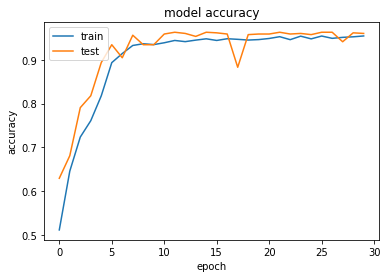

In [93]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

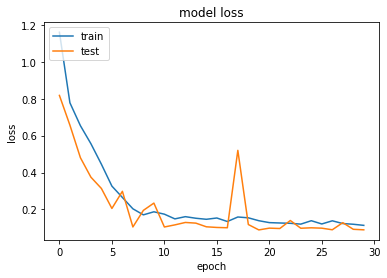

In [98]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [94]:
# Confusion Matrix
print(confusion_matrix(Y_test, model1.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  7      392        90        0                   1   
STANDING                 0       99       433        0                   0   
WALKING                  0        0         0      445                  47   
WALKING_DOWNSTAIRS       0        0         0        0                 420   
WALKING_UPSTAIRS         0        0         0        1                  10   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            1  
STANDING                           0  
WALKING                            4  
WALKING_DOWNSTAIRS                 0  
WALKING_UPSTAIRS                 460  


In [95]:
score1 = model1.evaluate(X_test, Y_test)

2947/2947 [==============================] - 4s 1ms/step


In [96]:
score1

[0.3891164319865662, 0.9117746949195862]